## Trees, Trees, more Trees, oh my!!

unrooted phylogenetic trees without pendant edges


### Imports

In [1]:
import random

import pytest

import geomstats.backend as gs
from geomstats.geometry.stratified.bhv_space import (
    Tree,
    TreeSpace,
    TreeTopology,
)
from geomstats.geometry.stratified.trees import Split, generate_splits

gs.random.seed(666)

### generate_splits tests

In [2]:
labels3 = list(range(3))
labels4 = list(range(4))
labels5 = list(range(5))
n = random.randint(6, 9)
labelsn = list(range(n))

## Three things can be partitioned three ways
splits3 = generate_splits(labels3, exclude_singletons=False)
assert len(splits3) == 3

## No splits for three things with no singleton splits
splits3_no_singletons = generate_splits(labels3, exclude_singletons=True)
assert len(splits3_no_singletons) == 0

## according to Billera et al. (2001, p.743) there are (2N − 3)!! := 5 · 3 · 1 = 15
## different possible choices of compatible subsets E ⊂ fancy_E with |E| = N − 2 = 2.
## note: N = n - 1 because they do not count the root as a leaf eventhough it is
splitsn = generate_splits(labelsn, exclude_singletons=True)
assert len(splitsn) == n - 3

### TreeTopology tests

In [3]:
## Empty split not allowed
illegal_empty_topology = (Split({}, {0, 1, 2, 3, 4}), Split({0, 1}, {2, 3, 4}))
expected_error_message = "Empty splits like .* are not allowed."

with pytest.raises(ValueError, match=expected_error_message):
    TreeTopology(illegal_empty_topology)

## Singleton split not allowed
illegal_pendant_topology = (Split({3}, {0, 4, 1, 2}), Split({0, 1}, {2, 3, 4}))
expected_error_message = "Pendant edges / singleton splits like .* are not allowed."

with pytest.raises(ValueError, match=expected_error_message):
    TreeTopology(illegal_pendant_topology)

## This one is fine
legal_topology = (Split({3, 4}, {0, 1, 2}), Split({0, 1}, {2, 3, 4}))
legal_tt = TreeTopology(legal_topology)

assert legal_tt.splits == legal_topology
assert legal_tt.n_labels == 5

## Star tree should work
star_tree_topology = ()
star_tt = TreeTopology(star_tree_topology, n_labels=5)

assert star_tt.splits == star_tree_topology
assert star_tt.n_labels == 5

### TreeTopology tests

In [4]:
legal_lengths = [2, 4]
illegal_zero_length = [0, 3]
illegal_negative_length = [-2, 3]
illegal_number_of_lengths = [1, 2, 3]
star_tree_lengths = []

legal_topology = (Split({3, 4}, {0, 1, 2}), Split({0, 1}, {2, 3, 4}))
illegal_empty_topology = (Split({}, {0, 1, 2, 3, 4}), Split({0, 1}, {2, 3, 4}))
illegal_pendant_topology = (Split({3}, {0, 4, 1, 2}), Split({0, 1}, {2, 3, 4}))
star_tree_topology = ()

## Empty split not allowed
expected_error_message = "Empty splits like .* are not allowed."
with pytest.raises(ValueError, match=expected_error_message):
    Tree(illegal_empty_topology, legal_lengths)

## Singleton split not allowed
expected_error_message = "Pendant edges / singleton splits like .* are not allowed."
with pytest.raises(ValueError, match=expected_error_message):
    Tree(illegal_pendant_topology, legal_lengths)

## Zero length not allowed
expected_error_message = "Lengths must be positive. .* is not allowed."
with pytest.raises(ValueError, match=expected_error_message):
    Tree(legal_topology, illegal_zero_length)

## Negative length not allowed
expected_error_message = "Lengths must be positive. .* is not allowed."
with pytest.raises(ValueError, match=expected_error_message):
    Tree(legal_topology, illegal_negative_length)

## Lengths must match number of splits
expected_error_message = "Splits and lengths different size. .*"
with pytest.raises(ValueError, match=expected_error_message):
    Tree(legal_topology, illegal_number_of_lengths)

## This one is fine
tree = Tree(legal_topology, legal_lengths)
assert len(tree.lengths) == len(legal_lengths)

## Star tree should work
star_tree = Tree(star_tree_topology, star_tree_lengths, n_labels=5)
assert len(star_tree.lengths) == 0

### TreeSpace tests

In [5]:
# BHV space only defined with N >= 4
expected_error_message = "BHV space only defined for N >= 4.*"
with pytest.raises(ValueError, match=expected_error_message):
    TreeSpace(n_labels=2)

# This is fine.
bhv5 = TreeSpace(n_labels=5)

# Make random point and check if belongs in space
random_tree = bhv5.random_point()
assert bhv5.belongs(random_tree)

# Check handling of non-tree
assert not bhv5.belongs("imposter")

# make random point in other space and make sure it doesn't belong
bhv7 = TreeSpace(n_labels=7)
assert not bhv7.belongs(random_tree)

### BHVMetric tests

https://plewis.github.io/applets/bhvspace/

^^ v helpful for visualisation and test creation

In [6]:
# These trees can have max two compatible splits out of ten total.
bhv5 = TreeSpace(n_labels=5)

top_quartile_topology = (Split({3, 4}, {0, 1, 2}), Split({0, 1}, {2, 3, 4}))
left_quartile_topology = (Split({2, 3}, {0, 1, 4}), Split({0, 4}, {3, 1, 2}))
right_quartile_topology = (Split({2, 3}, {0, 1, 4}), Split({0, 1}, {2, 3, 4}))
right_stratum_topology = (Split({0, 1}, {2, 3, 4}),)
lengths = gs.array([3, 1])

top_tree = Tree(top_quartile_topology, lengths)
top_tree_shifted = Tree(top_quartile_topology, lengths + 1)
right_tree = Tree(right_quartile_topology, lengths)
mirrored_left_tree = Tree(left_quartile_topology, lengths)
halfway_tree_right = Tree(right_stratum_topology, [1])
star_tree = Tree((), [], n_labels=5)

## Distance same quadrant
dist = bhv5.metric.dist(top_tree, top_tree_shifted)
expected_dist = 2**0.5
assert gs.abs(dist - expected_dist) < gs.atol

## Distance different quadrant, vertical line
dist = bhv5.metric.dist(top_tree, right_tree)
expected_dist = 6
assert gs.abs(dist - expected_dist) < gs.atol

## Distance different quadrant, diagonal line
dist = bhv5.metric.dist(top_tree_shifted, right_tree)
expected_dist = (1 + 7**2) ** 0.5
assert gs.abs(dist - expected_dist) < gs.atol

## Distance different quadrant, geodesic through origin
dist = bhv5.metric.dist(top_tree, mirrored_left_tree)
expected_dist = 2 * (1 + 3**2) ** 0.5
assert gs.abs(dist - expected_dist) < gs.atol

## Geodesic same quadrant
geodesic = bhv5.metric.geodesic(top_tree, top_tree_shifted)
beginning = geodesic(0)
halfway = geodesic(0.5)
end = geodesic(1)
expected_halfway = Tree(top_quartile_topology, lengths + 0.5)
assert beginning.equal(top_tree)
assert halfway.equal(expected_halfway)
assert end.equal(top_tree_shifted)

## Geodesic different quadrant
geodesic = bhv5.metric.geodesic(top_tree, right_tree)
beginning = geodesic(0)
halfway = geodesic(0.5)
end = geodesic(1)
assert beginning.equal(top_tree)
assert halfway.equal(halfway_tree_right)
assert end.equal(right_tree)

## Geodesic different quadrant, geodesic through origin
geodesic = bhv5.metric.geodesic(top_tree, mirrored_left_tree)
beginning = geodesic(0)
less_than_halfway = geodesic(0.3)
halfway = geodesic(0.5)
more_than_halfway = geodesic(0.7)
end = geodesic(1)
expected_less_than_halfway = Tree(top_quartile_topology, [1.2, 0.4])
expected_more_than_halfway = Tree(left_quartile_topology, [1.2, 0.4])
assert beginning.equal(top_tree)
assert less_than_halfway.equal(expected_less_than_halfway)
assert halfway.equal(star_tree)
assert more_than_halfway.equal(expected_more_than_halfway)
assert end.equal(mirrored_left_tree)

## Geodesic illegal actions
geodesic = bhv5.metric.geodesic(top_tree, mirrored_left_tree)

expected_error_message = "Geodesics only exist for 0<=t<=1.*"
with pytest.raises(ValueError, match=expected_error_message):
    geodesic(-1)
with pytest.raises(ValueError, match=expected_error_message):
    geodesic(1.1)

### Multidimensional Scaling (MDS)

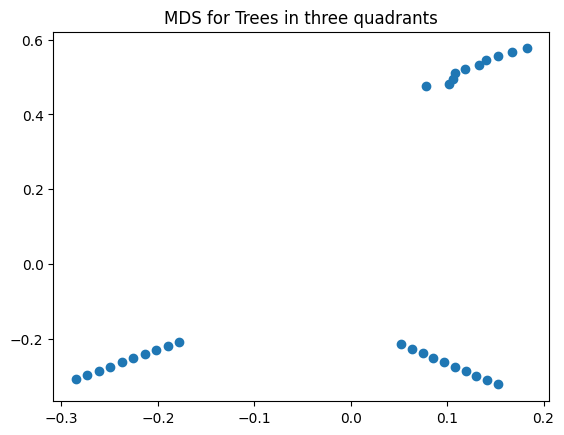

In [10]:
import matplotlib.pyplot as plt

from geomstats.learning.mds import MetricMDS

bhv5 = TreeSpace(n_labels=5)

top_quartile_topology = (Split({3, 4}, {0, 1, 2}), Split({0, 1}, {2, 3, 4}))
left_quartile_topology = (Split({2, 3}, {0, 1, 4}), Split({0, 4}, {3, 1, 2}))
right_quartile_topology = (Split({2, 3}, {0, 1, 4}), Split({0, 1}, {2, 3, 4}))
right_stratum_topology = (Split({0, 1}, {2, 3, 4}),)
lengths = gs.array([3, 1])

trees = [Tree(top_quartile_topology, lengths + i * 0.1) for i in range(10)]
trees.extend([Tree(right_quartile_topology, lengths + i * 0.1) for i in range(10)])
trees.extend([Tree(left_quartile_topology, lengths + i * 0.1) for i in range(10)])

mds = MetricMDS(bhv5)
fit_mds = mds.fit_transform(trees)

plt.scatter(fit_mds[:, 0], fit_mds[:, 1])
plt.title("MDS for Trees in three quadrants")
plt.show()